# DML Diff-in-Diff


In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing
import seaborn as sns

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier, XGBRegressor


We will focus on the the Ddata generating processes from [Sant'Anna and Zhao (2020)](https://arxiv.org/abs/1812.01723), see Section 4.1 and 4.2.

In [2]:
def f_reg(W):
  res = 210 + 27.4*W[:, 0] + 13.7*(W[:, 1] + W[:, 2] + W[:, 3])
  return res

def f_ps(W):
  res = 0.75*(-W[:, 0] + 0.5*W[:, 1] - 0.25*W[:, 2] - 0.1*W[:, 3])
  return res

def dgp(n=200, dgp_type=1):
  # features
  X = np.random.normal(loc=0, scale=1, size=[n,4])
  Z_tilde_1 = np.exp(0.5*X[:, 0])
  Z_tilde_2 = 10 + X[:, 1] / (1 + np.exp(X[:, 0]))
  Z_tilde_3 = (0.6 + X[:, 0]*X[:, 2]/25)**3
  Z_tilde_4 = (20 + X[:, 1] + X[:, 3])**2

  Z_tilde = np.column_stack((Z_tilde_1, Z_tilde_2, Z_tilde_3, Z_tilde_4))
  Z = (Z_tilde - np.mean(Z_tilde, axis=0)) / np.std(Z_tilde, axis=0)
  
  # error terms
  epsilon_0 = np.random.normal(loc=0, scale=1, size=n)
  epsilon_1 = np.random.normal(loc=0, scale=1, size=[n,2])
  if dgp_type == 1:
    features_ps = Z
    features_reg = Z
  elif dgp_type == 2:
    features_ps = X
    features_reg = Z
  elif dgp_type == 3:
    features_ps = Z
    features_reg = X
  elif dgp_type == 4:
    features_ps = X
    features_reg = X
  else:
    ValueError("DGP type not specified")

  # treatment and propensities
  p = np.exp(f_ps(features_ps)) / (1 + np.exp(f_ps(features_ps)))
  U = np.random.uniform(low=0, high=1, size=n)
  D = 1.0 * (p >= U)

  # potential outcomes
  nu =  np.random.normal(loc=D*f_reg(features_reg), scale=1, size=n)
  Y0 = f_reg(features_reg) + nu + epsilon_0
  Y1_d0 = 2*f_reg(features_reg) + nu + epsilon_1[:, 0]
  Y1_d1 = 2*f_reg(features_reg) + nu + epsilon_1[:, 1]
  Y1 = D*Y1_d1 + (1-D)*Y1_d0

  return Y0, Y1, D, Z, Y1_d0, Y1_d1


The ATT should be zero. We will check this numerically:

In [3]:
dgp_types = [1, 2, 3, 4]
n_dgps = len(dgp_types)

for dgp_type in dgp_types:  
    _, _, D, _, Y1_d0, Y1_d1 = dgp(int(10e+6), dgp_type=dgp_type)
    ATT = np.mean(Y1_d1[D == 1] - Y1_d0[D == 1])
    print(f'ATT (DGP={dgp_type}): {ATT}')
# Set the true ATT to zero
ATT = 0

ATT (DGP=1): 0.0003048138339405014
ATT (DGP=2): -0.0005357545552229088
ATT (DGP=3): 7.015588986036638e-05
ATT (DGP=4): -0.0007254919985098836


In [4]:
np.random.seed(42)
n_rep = 10
n_obs = 1000
lambda_T = 0.5

datasets = []
for dgp_type in dgp_types:
    datasets_dgp = []
    for i in range(n_rep):
        Y0, Y1, D, X, _, _ = dgp(n=n_obs, dgp_type=dgp_type)

        # datasets with repeated cross sections
        U_T = np.random.uniform(low=0, high=1, size=n_obs)
        T = 1.0 * (U_T <= lambda_T)
        Y_obs = T * Y1 + (1-T)*Y0
        data = dml.DoubleMLDIDData.from_arrays(X, Y_obs, D, T)
        datasets_dgp.append(data)
    datasets.append(datasets_dgp)

In [5]:
n_estimators = 50

# Random Forest
# ml_g = RandomForestRegressor(n_estimators=n_estimators)
# ml_m = RandomForestClassifier(n_estimators=n_estimators)

# Boosted Trees
ml_g = XGBRegressor(n_jobs=1, objective = "reg:squarederror",
                    eta=0.1, n_estimators=n_estimators)
ml_m = XGBClassifier(n_jobs=1, objective = "binary:logistic",
                     eval_metric = "logloss",
                     eta=0.1, n_estimators=n_estimators)

# linear models
#ml_g = LinearRegression()
#ml_m = LogisticRegression()

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")
# to be process folds in parallel
cores_used = 5

Number of Cores: 24


## Repeated Cross-sectional Data

Use the same data with coss-sectional observations

In [6]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [7]:
coefs_ch = np.full((n_rep, n_dgps), np.nan)
ses_ch = np.full((n_rep, n_dgps), np.nan)
cover_ch = np.full((n_rep, n_dgps), np.nan)
ci_length_ch = np.full((n_rep, n_dgps), np.nan)

coefs_zi_1 = np.full((n_rep, n_dgps), np.nan)
ses_zi_1 = np.full((n_rep, n_dgps), np.nan)
cover_zi_1 = np.full((n_rep, n_dgps), np.nan)
ci_length_zi_1 = np.full((n_rep, n_dgps), np.nan)

coefs_zi_2 = np.full((n_rep, n_dgps), np.nan)
ses_zi_2 = np.full((n_rep, n_dgps), np.nan)
cover_zi_2 = np.full((n_rep, n_dgps), np.nan)
ci_length_zi_2 = np.full((n_rep, n_dgps), np.nan)

for i_dgp, dgp_type in enumerate(dgp_types):
    print(f'DPG={dgp_type}')
    for i_rep in range(n_rep):
        if (i_rep % int(n_rep/10)) == 0:
            print(f'Iteration: {i_rep}')
        obj_dml_data = datasets[i_dgp][i_rep]
        with suppress_stdout():
            # estimate ATT with Chang
            dml_DiD_ch = dml.DoubleMLDID(obj_dml_data,
                                        ml_g=clone(ml_g),
                                        ml_m=clone(ml_m),
                                        score='RCS',
                                        n_folds=5)

            dml_DiD_ch.fit(n_jobs_cv=cores_used)

            # estimate ATT with Zimmert and Sant'Anna
            dml_DiD_zi_1 = dml.DoubleMLDiDCS(obj_dml_data,
                                        ml_g=clone(ml_g),
                                        ml_m=clone(ml_m),
                                        score='CS-4',
                                        n_folds=5)

            dml_DiD_zi_1.fit(n_jobs_cv=cores_used)

        # estimate ATT with Zimmert (not efficient)
        dml_DiD_zi_2 = dml.DoubleMLDiDCS(obj_dml_data,
                                    ml_g=clone(ml_g),
                                    ml_m=clone(ml_m),
                                    score='CS*-4',
                                    n_folds=5)

        dml_DiD_zi_2.fit(n_jobs_cv=cores_used)

        # save coefs and ses
        coefs_ch[i_rep, i_dgp] = dml_DiD_ch.coef
        ses_ch[i_rep, i_dgp] = dml_DiD_ch.se

        # calculate confidence interval
        confint_ch = dml_DiD_ch.confint(level=0.95)
        cover_ch[i_rep, i_dgp] = (confint_ch['2.5 %'] < ATT) & (ATT < confint_ch['97.5 %'])
        ci_length_ch[i_rep, i_dgp] = confint_ch['97.5 %'] - confint_ch['2.5 %']

        # save coefs and ses
        coefs_zi_1[i_rep, i_dgp] = dml_DiD_zi_1.coef
        ses_zi_1[i_rep, i_dgp] = dml_DiD_zi_1.se

        # calculate confidence interval
        confint_zi_1 = dml_DiD_zi_1.confint(level=0.95)
        cover_zi_1[i_rep, i_dgp] = (confint_zi_1['2.5 %'] < ATT) & (ATT < confint_zi_1['97.5 %'])
        ci_length_zi_1[i_rep, i_dgp] = confint_zi_1['97.5 %'] - confint_zi_1['2.5 %']

        # save coefs and ses
        coefs_zi_2[i_rep, i_dgp] = dml_DiD_zi_2.coef
        ses_zi_2[i_rep, i_dgp] = dml_DiD_zi_2.se

        # calculate confidence interval
        confint_zi_2 = dml_DiD_zi_2.confint(level=0.95)
        cover_zi_2[i_rep, i_dgp] = (confint_zi_2['2.5 %'] < ATT) & (ATT < confint_zi_2['97.5 %'])
        ci_length_zi_2[i_rep, i_dgp] = confint_zi_2['97.5 %'] - confint_zi_2['2.5 %']

DPG=1
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
DPG=2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
DPG=3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
DPG=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


## Results Chang

In [9]:
print(f'Avg. Bias: {coefs_ch.mean(0)}')
print(f'RMSE: {np.sqrt(np.square(coefs_ch)).mean(0)}')
print(f'Avg. asymptotic Variance: {np.square(ses_ch).mean(0)}')
print(f'Coverage: {cover_ch.mean(0)}')
print(f'Avg. CI length: {ci_length_ch.mean(0)}')

Avg. Bias: [-5.46851576 -2.1540094  -5.4749057  -7.52324991]
RMSE: [ 6.88822453 11.37310114 11.61939598  9.92874278]
Avg. asymptotic Variance: [246.95357665 281.85283641 249.83410982 327.51193879]
Coverage: [1. 1. 1. 1.]
Avg. CI length: [61.5127149  65.63711825 61.91940119 70.67144729]


## Results Zimmert and Sant'Anna

In [10]:
print(f'Avg. Bias: {coefs_zi_1.mean(0)}')
print(f'RMSE: {np.sqrt(np.square(coefs_zi_1)).mean(0)}')
print(f'Avg. asymptotic Variance: {np.square(ses_zi_1).mean(0)}')
print(f'Coverage: {cover_zi_1.mean(0)}')
print(f'Avg. CI length: {ci_length_zi_1.mean(0)}')

Avg. Bias: [-1.18824269 -1.11952649  0.0757818   0.52908827]
RMSE: [4.85584641 3.49429261 4.42618405 3.99785919]
Avg. asymptotic Variance: [21.2882964  27.21006482 24.71400012 64.82900222]
Coverage: [0.9 1.  1.  1. ]
Avg. CI length: [17.72715698 20.22525291 19.17813789 31.00034414]


## Results Zimmert (not efficient)

In [11]:
print(f'Avg. Bias: {coefs_zi_2.mean(0)}')
print(f'RMSE: {np.sqrt(np.square(coefs_zi_2)).mean(0)}')
print(f'Avg. asymptotic Variance: {np.square(ses_zi_2).mean(0)}')
print(f'Coverage: {cover_zi_2.mean(0)}')
print(f'Avg. CI length: {ci_length_zi_2.mean(0)}')

Avg. Bias: [-10.99385253  -2.52738917 -11.83891951  -8.92245404]
RMSE: [15.93130733 25.08362616 26.40456952 23.34137792]
Avg. asymptotic Variance: [2119.9473935  2211.93459057 2135.68477477 2114.75967932]
Coverage: [1. 1. 1. 1.]
Avg. CI length: [180.47523682 184.33036506 181.1404997  180.21300798]


## Comparison

In [12]:
df_ch = pd.DataFrame(coefs_ch,
                     columns=["1", "2", "3", "4"])
df2_ch = pd.melt(df_ch, value_name='Estimated ATT', var_name='DGP')
df2_ch["Alg"] = "Chang"

df_zi_1 = pd.DataFrame(coefs_zi_1,
                     columns=["1", "2", "3", "4"])
df2_zi_1 = pd.melt(df_zi_1, value_name='Estimated ATT', var_name='DGP')
df2_zi_1["Alg"] = "Zimmert"

df_zi_2 = pd.DataFrame(coefs_zi_2,
                     columns=["1", "2", "3", "4"])
df2_zi_2 = pd.melt(df_zi_2, value_name='Estimated ATT', var_name='DGP')
df2_zi_2["Alg"] = "Zimmert (not efficient)"

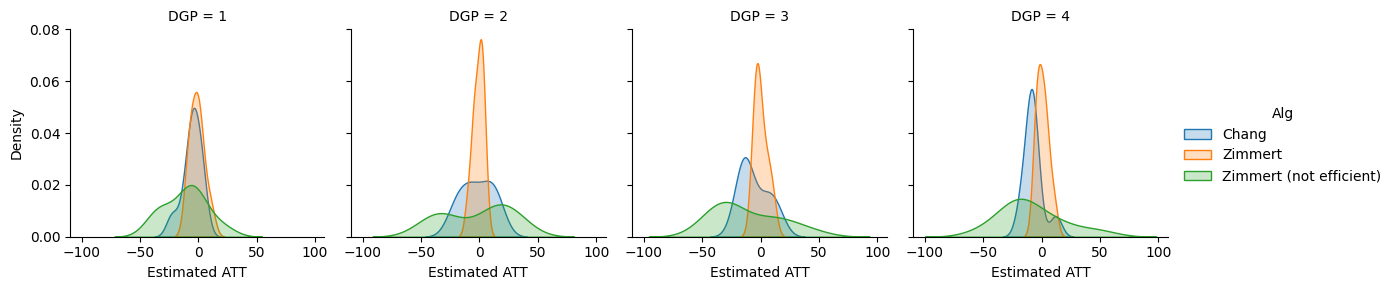

In [13]:
df_plot = pd.concat([df2_ch, df2_zi_1, df2_zi_2], axis=0)
g = sns.FacetGrid(df_plot, col="DGP", hue="Alg")
g.map_dataframe(sns.kdeplot, x="Estimated ATT", fill=True)
g.add_legend()